In [1]:
%pylab inline --no-import-all

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import MyDijetKernelSimp

import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

### Load all inputs

In [3]:
#Full bin centers (xvalO), counts (yvalO), bin width (xerrO), and bin low edges (xlowO) from ATLAS
xvalO = np.load("savedOutputs/xvalO.npy")
yvalO = np.load("savedOutputs/yvalO.npy")
xerrO = np.load("savedOutputs/xerrO.npy")
xlowO = np.load("savedOutputs/xlowO.npy")

#Same, but with bins with zero counts removed. GP fits better without zero counts
xval = np.load("savedOutputs/xval.npy")
yval = np.load("savedOutputs/yval.npy")
xerr = np.load("savedOutputs/xerr.npy")

#10000 toys - created from 5 parameter fit to data with Poisson noise
toyList = np.load("savedOutputs/toyList.npy")
#10000 toys at different luminosities. Created the same as previous toys but scaled to correct lumi
lumiToyDict = np.load("savedOutputs/lumiToyList.npy")
#GP fit to ATLAS data. Done with Gibbs kernel and 3 parameter fit function as mean. Fit all parameters (kernel and mean)
meanGPnom = np.load("savedOutputs/initialGPfit.npy")
#hyperparameters (kernel and mean) from GP fit to ATLAS data.
fixedHyperparams = np.load("savedOutputs/fixedHyperparams.npy")
#Gaussian signal parameters (amplitude, mean, and width) for different masses
standardParamSets = [(1500,2000,250), (750 ,2500, 250), (200, 3000, 250), (75, 3500, 250), (50, 4000, 250), 
             (25, 4500, 250), (20, 5000, 250), (15,5500, 250), (15, 6000,250)]
#10000 Gaussian signals at each mass point with Poisson noise at bin xval (zero bins removed)
sigToys = np.load("savedOutputs/signalToys.npy")
#10000 Gaussian signals at each mass point with Poisson noise at bins xvalO (original ATLAS binning)
sigToysO = np.load("savedOutputs/signalToysO.npy")



#### Gaussian signal function

In [4]:
def sig_model(x, N=1e5, mass=2000., width=100., xErr=xerr):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xErr

#### 3 and 5 parameter fit functions

In [5]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr)  
def model_5param(t, params, xErr=xerr): 
    p0, p1, p2, p3, p4 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2+p3*np.log(t/sqrts)+p4*np.log(t/sqrts)**2))*(xErr)

#### Calculate z value and chi squared

In [6]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

#### Poisson log likelihood

In [21]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

In [22]:
def simpleLogPoisson_nogamma(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par 
        return lnpoisson
    

def logLike_gpLikeFF_nogamma(y1, y2):
    logL = 0
    for ibin in range(len(y1)):
        data = y1[ibin]
        bkg = y2[ibin]
        logL += -simpleLogPoisson_nogamma(data, bkg)
    try:
        logL
        return logL
    except:
        return np.inf  

class logLike_3ff_nogamma:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson_nogamma(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_3ff_sig_nogamma:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, N):
        params = p0, p1, p2
        nSignal = N
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += -simpleLogPoisson_nogamma(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf
        
class logLike_5ff_nogamma:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2, p3, p4):
        params = p0, p1, p2, p3, p4
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            logL += -simpleLogPoisson_nogamma(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_5ff_sig_nogamma:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, p3, p4, N):
        params = p0, p1, p2, p3, p4
        nSignal = N
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += -simpleLogPoisson_nogamma(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf

In [23]:
def simpleGaussian(d, b):
    if d < 0: 
        return np.inf
    elif d == 0: return 0
    else:
        lnGaus = 0.5*((d-b)/np.sqrt(d))**2
        return lnGaus
    
def logLike_gpLikeFF_gaus(y1, y2):
    logL = 0
    for ibin in range(len(y1)):
        data = y1[ibin]
        bkg = y2[ibin]
        logL += simpleGaussian(data, bkg)
    try:
        logL
        return logL
    except:
        return np.inf  

class logLike_3ff_gaus:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += simpleGaussian(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_3ff_sig_gaus:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, N):
        params = p0, p1, p2
        nSignal = N
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += simpleGaussian(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf
        
class logLike_5ff_gaus:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2, p3, p4):
        params = p0, p1, p2, p3, p4
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            logL += simpleGaussian(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_5ff_sig_gaus:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, p3, p4, N):
        params = p0, p1, p2, p3, p4
        nSignal = N
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += simpleGaussian(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf   
    



#### remove zero count bins - makes GP smoother 

In [24]:
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

#### Plot distribution of log likelihood ratio with chi2 drawn on top

In [61]:
def makePrettyPlots_LLH(GP_LLH, FF_LLH, title, drawchi2=False, xname=r'$\chi^{2}$', label1 = "Gaussian Process", label2 = "Fit Function"):
    f, (ax1, ax2) = plt.subplots(2, figsize=(12,12), gridspec_kw = {'height_ratios':[1, 1]})
    f.suptitle(title, fontsize=30)

    lowx = min(min(GP_LLH), min(FF_LLH))
    #highx = max(max(GP_LLH), max(FF_LLH))
    #lowx = 0.01
    highx = 10

    
    bins = np.linspace(lowx, highx, 200)
    dx = bins[1]-bins[0]
    bin_centers = bins[:-1] + dx/2.
    hGP, _, _ =ax1.hist(GP_LLH, bins=bins, color="b")
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_title(label1, fontsize=20)
    if drawchi2:
        chi2_gp =sum(hGP)*(bins[1]-bins[0])*ss.chi2.pdf(bin_centers, 1.)
        ax1.plot(bin_centers, chi2_gp, c='r', linewidth=2)
    
    
    hFF, _, _ =ax2.hist(FF_LLH, bins=bins, color='g')
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.set_xlabel(xname, fontsize=30)
    ax2.set_title(label2, fontsize=20)
    if drawchi2:
        chi2_ff = sum(hFF)*(bins[1]-bins[0])*ss.chi2.pdf(bin_centers, 1.) 
        ax2.plot(bin_centers, chi2_ff, c='r', linewidth=2)



    plt.show()




#### Poisson log likelihoods for Gaussian Process, 3 parameter fit function, 3 parameter fit function with signal strength parameter, 5 parameter fit function, and 5 parameter fit function with signal strength parameter. Goes into minuit to minimize

In [26]:
def logLike_gpLikeFF(y1, y2):
    logL = 0
    for ibin in range(len(y1)):
        data = y1[ibin]
        bkg = y2[ibin]
        logL += -simpleLogPoisson(data, bkg)
    try:
        logL
        return logL
    except:
        return np.inf  

class logLike_3ff:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    

    
class logLike_3ff_sig:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, N):
        params = p0, p1, p2
        nSignal = N
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += -simpleLogPoisson(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf
        
class logLike_5ff:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2, p3, p4):
        params = p0, p1, p2, p3, p4
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_5ff_sig:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, p3, p4, N):
        params = p0, p1, p2, p3, p4
        nSignal = N
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += -simpleLogPoisson(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf

#### Minuit minimization of 3 parameter fit function, 3 parameter fit function + signal, 5 parameter fit function, and 5 parameter fit function with signal

In [40]:
def fit_3ff(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 10:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * -6.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, 
                  limit_p0 = (0, 20.), limit_p1 = (-20., 20.), limit_p2 = (-20., 20.))

        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 9: 
            print "retry number = ", 10, ": failed fits", lnprob.__class__.__name__
            minLLH=np.inf
            best_fit_params=(0, 0, 0)
        numRetries+=1

    if Print:
        print "min LL", minLLH
        print "best fit vals", best_fit_params
    return minLLH, best_fit_params

def fit_3ff_sig(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 15:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * -6.
        init3 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2, N = init3,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, error_N = 1e-4,
                  limit_p0 = (0, 20.), limit_p1 = (-20., 20.), limit_p2 = (-20., 20.), limit_N = (0, 100))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 14: 
            print "retry number = ", 15, ": failed fits", lnprob.__class__.__name__
            minLLH=np.inf
            best_fit_params=(0, 0, 0, 0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params

def fit_5ff(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 10:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * -6.
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2, p3 = init3, p4 = init4,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, error_p3 = 1e-2, error_p4 = 1e-2,
                  limit_p0 = (0, 10), limit_p1 = (-20, 20), limit_p2 = (-20, 20), 
                   limit_p3 = (-10, 10), limit_p4 = (-20, 20))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 9: 
            print "retry number = ", 10, ": failed fits", lnprob.__class__.__name__
            minLLH=np.inf
            best_fit_params=(0, 0, 0, 0, 0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals", best_fit_params
    return minLLH, best_fit_params

def fit_5ff_sig(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0., 0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 15:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * -6.
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        init5 = np.random.random() * 1
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2, p3 = init3, p4 = init4, N = init5,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, error_p3 = 1e-2, error_p4 = 1e-2, error_N = 1e-4,
                  limit_p0 = (0, 10), limit_p1 = (-20, 20), limit_p2 = (-20, 20), 
                   limit_p3 = (-10, 10), limit_p4 = (-20, 20), limit_N = (0, 100))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 14: 
            print "retry number = ", 15, ": failed fits", lnprob.__class__.__name__
            minLLH=np.inf
            best_fit_params=(0, 0, 0, 0, 0, 0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params

#### Gaussian Process fit. model_gp is 3 parameter fit function used as mean. log likelihood calculation from george where kernel and mean parameters are fixed and only signal strength parameter is fit. Fit using minuit

In [28]:
def model_gp(params, t, xerr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

class logLike_gp_tempSig_fixedH:
    def __init__(self, x, y, xerr, sigTemp):
        self.x = x
        self.y = y
        self.xerr = xerr
        self.sigTemp = sigTemp
    def __call__(self, N):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr)-N*self.sigTemp)
        except:
            return np.inf        
        
def fit_gp_tempSig_fixedH_minuit(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, 
                   N = init0, error_N = 1e-4, limit_N = (0, 100)) 
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            minLLH=np.inf
            best_fit_params=(0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params




###  Background and signal+background fit on background toys only. To run over enough toys to get a good chi2 fit, only run on one signal mass point. Loop over 5000 toys and fit just background and background + a 3.5 TeV Gaussian signal. Background only prediction with fixed hyperparameters and mean parameters is in first part; fitting with minuit the signal strength for a signal + background prediction is in the second part. Calculate a log likehood ratio using george and using a Poisson likelihood.

In [29]:
standardParamSets = [(1500,2000,250), (15, 6000,250)]

In [47]:
btime=time.time()

LLlistGP={}
LLlistGPP={}
LLlistGPG={}
LLlistGPng={}
for pSet in standardParamSets:
    n, m, w = pSet
    print pSet
    LLlistGP[m]=[]
    LLlistGPP[m]=[]
    LLlistGPG[m]=[]
    LLlistGPng[m]=[]
        
    for itoy, toy in enumerate(toyList[:500]):
        if not itoy%500: 
            #np.save("LLH_GP", LLlistGP_b)
            print itoy
        ytoy, xtoy, xtoyerr = removeZeros(toy)
        signalTemplate = sigToys[()][m][itoy]
        ydata = ytoy

        signalTemplateO = sigToysO[()][m][itoy]
        ydataO = toy

        #BACKGROUND ONLY FIT GP
        if not itoy%500:
            pgpb_stime = time.time()
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp1 = george.GP(kernel1)
        gp1.compute(xtoy, np.sqrt(ydata))
        meanGP1p, covGP1 = gp1.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
        meanGP1 = meanGP1p+ model_3param(xvalO,(p0,p1,p2),xerrO)
        gpLLH = gp1.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))
        if not itoy%500:
            pgpb_etime = time.time()
            print "background only time:", pgpb_etime-pgpb_stime

        #BACKGROUND+SIGNAL FIT GP
        if not itoy%500:
            pgpsb_stime = time.time()
        lnProb = logLike_gp_tempSig_fixedH(xtoy,ydata, xtoyerr, signalTemplate)
        minLLH, best_fit_gp = fit_gp_tempSig_fixedH_minuit(lnProb, False)
        if np.isinf(minLLH): continue
        mu = best_fit_gp[0]
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp, covGP = gp.predict(ytoy - model_gp((p0,p1,p2),xtoy, xtoyerr) - mu*signalTemplate, xvalO)
        meanGP = meanGPp+ model_3param(xvalO,(p0,p1,p2),xerrO)
        meanGPsig = meanGP+mu*signalTemplateO
        gpLLHSig = gp.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr) - mu*signalTemplate)
        if not itoy%500:
            pgpsb_etime = time.time()
            print "background + signal time:", pgpsb_etime - pgpsb_stime
        
        LLlistGP[m].append(-2*(gpLLH-gpLLHSig))
        LLlistGPP[m].append(-2*(-logLike_gpLikeFF(ydataO, meanGP1)+logLike_gpLikeFF(ydataO, meanGPsig)))
        LLlistGPG[m].append(-2*(-logLike_gpLikeFF_gaus(ydataO, meanGP1)+logLike_gpLikeFF_gaus(ydataO, meanGPsig)))
        LLlistGPng[m].append(-2*(-logLike_gpLikeFF_nogamma(ydataO, meanGP1)+logLike_gpLikeFF_nogamma(ydataO, meanGPsig)))


etime = time.time()
print "took "+str((etime-btime)/(60.*60.)) + "hours"   

(1500, 2000, 250)
0
background only time: 0.0252130031586
background + signal time: 0.0403518676758
(15, 6000, 250)
0
background only time: 0.00291109085083
background + signal time: 0.0337839126587
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
retry number =  5 : failed fits
took 0.011970689959hours


### Background and signal+background fit on background toys only. To run over enough toys to get a good chi2 fit, only run on one signal mass point. Loop over 5000 toys and fit just background and background + a 3.5 TeV Gaussian signal. For background only prediction, fit with minuit the 3 and 5 parameter fit functions. For s+b prediction, fit 3 and 5 parameter fit functions with a signal strength parameter

In [42]:
btime=time.time()
'''
LLlistFF3={}
LLlistFF3G={}
LLlistFF3ng={}
LLlistFF5={}
LLlistFF5G={}
LLlistFF5ng={}

paramlistFF3_b={}
paramlistFF3G_b={}
paramlistFF3ng_b={}
paramlistFF3_sb={}
paramlistFF3G_sb={}
paramlistFF3ng_sb={}
paramlistFF5_b={}
paramlistFF5G_b={}
paramlistFF5ng_b={}
paramlistFF5_sb={}
paramlistFF5G_sb={}
paramlistFF5ng_sb={}
'''

for pSet in standardParamSets:
    n, m, w = pSet
    print pSet
    '''
    LLlistFF3[m]=[]
    LLlistFF5[m]=[] 
    LLlistFF3G[m]=[]
    LLlistFF5G[m]=[]
    LLlistFF3ng[m]=[]
    LLlistFF5ng[m]=[]
    paramlistFF3_b[m]=[]
    paramlistFF3G_b[m]=[]
    paramlistFF3ng_b[m]=[]
    paramlistFF3_sb[m]=[]
    paramlistFF3G_sb[m]=[]
    paramlistFF3ng_sb[m]=[]
    paramlistFF5_b[m]=[]
    paramlistFF5G_b[m]=[]
    paramlistFF5ng_b[m]=[]
    paramlistFF5_sb[m]=[]
    paramlistFF5G_sb[m]=[]
    paramlistFF5ng_sb[m]=[]
    '''

        
    for itoy, toy in enumerate(toyList[100:1000]):
        if not itoy%500: 
            np.save("LLH_3Param", LLlistFF3)
            np.save("LLH_5Param", LLlistFF5)
        if not itoy%10: 
            print itoy
        ytoy, xtoy, xtoyerr = removeZeros(toy)
        
        signalTemplate = sigToys[()][m][itoy]
        ydata = ytoy

        signalTemplateO = sigToysO[()][m][itoy]
        ydataO = toy
        

        #######################################################
        if not itoy%500:
            p3b_stime = time.time()
        #BACKGROUND ONLY 3 PARAM FIT
        ####
        lnProb3b = logLike_3ff(xvalO, ydataO ,xerrO)
        ll_b3, best_fit_params = fit_3ff(lnProb3b, False)
        paramlistFF3_b[m].append(best_fit_params)
        ####
        lnProb3Gb = logLike_3ff_gaus(xvalO, ydataO ,xerrO)
        ll_b3G, best_fit_params = fit_3ff(lnProb3Gb, False)
        paramlistFF3G_b[m].append(best_fit_params)
        ####
        lnProb3ngb = logLike_3ff_nogamma(xvalO, ydataO ,xerrO)
        ll_b3ng, best_fit_params = fit_3ff(lnProb3ngb, False)
        paramlistFF3ng_b[m].append(best_fit_params)
        ####
        if not itoy%500:
            p3b_etime = time.time()
            print "background only 3 param: ", p3b_etime - p3b_stime
        
        
        #####################################################
        if not itoy%500:
            p3sb_stime = time.time()
        #BACKGROUND+SIGNAL 3 PARAM FIT
        lnProb3sb = logLike_3ff_sig(xvalO,ydataO,xerrO, signalTemplateO)
        ll_sb3, best_fit_params = fit_3ff_sig(lnProb3sb, False)
        paramlistFF3_sb[m].append(best_fit_params)
        ####
        lnProbG3sb = logLike_3ff_sig_gaus(xvalO,ydataO,xerrO, signalTemplateO)
        ll_sb3G, best_fit_params = fit_3ff_sig(lnProbG3sb, False)
        paramlistFF3G_sb[m].append(best_fit_params)
        ####        
        lnProbng3sb = logLike_3ff_sig_nogamma(xvalO,ydataO,xerrO, signalTemplateO)
        ll_sb3ng, best_fit_params = fit_3ff_sig(lnProbng3sb, False)
        paramlistFF3ng_sb[m].append(best_fit_params)
        ####
        if not itoy%500:
            p3sb_etime = time.time()
            print "s+b 3 param: ", p3sb_etime - p3sb_stime
        LLlistFF3[m].append(-2*(-ll_b3+ll_sb3))
        LLlistFF3G[m].append(-2*(-ll_b3G+ll_sb3G))
        LLlistFF3ng[m].append(-2*(-ll_b3ng+ll_sb3ng))

        #################################################################
            

        if not itoy%500:
            p5b_stime = time.time()
        #BACKGROUND ONLY 5 PARAM FIT
        lnProb5b = logLike_5ff(xvalO, ydataO ,xerrO)
        ll_b5, best_fit_params = fit_5ff(lnProb5b, False)
        paramlistFF5_b[m].append(best_fit_params)
        ####
        lnProbG5b = logLike_5ff_gaus(xvalO, ydataO ,xerrO)
        ll_b5G, best_fit_params = fit_5ff(lnProbG5b, False)
        paramlistFF5G_b[m].append(best_fit_params)
        ####
        lnProbng5b = logLike_5ff_nogamma(xvalO, ydataO ,xerrO)
        ll_b5ng, best_fit_params = fit_5ff(lnProbng5b, False)
        paramlistFF5ng_b[m].append(best_fit_params)
        if not itoy%500:
            p5b_etime = time.time()
            print "background only 5 param: ", p5b_etime - p5b_stime
            
        #############################################################
        if not itoy%500:
            p5sb_stime = time.time()
        #BACKGROUND+SIGNAL 5 PARAM FIT
        lnProb5sb = logLike_5ff_sig(xvalO,ydataO,xerrO, signalTemplateO)
        ll_sb5, best_fit_params = fit_5ff_sig(lnProb5sb, False)
        paramlistFF5_sb[m].append(best_fit_params)
        ####
        lnProbG5sb = logLike_5ff_sig_gaus(xvalO,ydataO,xerrO, signalTemplateO)
        ll_sb5G, best_fit_params = fit_5ff_sig(lnProbG5sb, False)
        paramlistFF5G_sb[m].append(best_fit_params)
        ####
        lnProbng5sb = logLike_5ff_sig_nogamma(xvalO,ydataO,xerrO, signalTemplateO)
        ll_sb5ng, best_fit_params = fit_5ff_sig(lnProbng5sb, False)
        paramlistFF5ng_sb[m].append(best_fit_params)
        ####
        if not itoy%500:
            p5sb_etime = time.time()
            print "s+b 3 param: ", p5sb_etime - p5sb_stime
        LLlistFF5[m].append(-2*(-ll_b5+ll_sb5))
        LLlistFF5G[m].append(-2*(-ll_b5G+ll_sb5G))
        LLlistFF5ng[m].append(-2*(-ll_b5ng+ll_sb5ng))        

 
        
etime = time.time()
print "took "+str((etime-btime)/(60.*60.)) + "hours"   

(1500, 2000, 250)
0
retry number =  10 : failed fits logLike_3ff_nogamma
background only 3 param:  3.36509895325
s+b 3 param:  2.64939689636
background only 5 param:  1.74800300598
s+b 3 param:  4.2886838913
retry number =  15 : failed fits logLike_5ff_sig_nogamma


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in double_scalars


10
retry number =  15 : failed fits logLike_5ff_sig_nogamma
20
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  15 : failed fits logLike_5ff_sig_nogamma
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  15 : failed fits logLike_5ff_sig_nogamma
retry number =  15 : failed fits logLike_3ff_sig_nogamma
30
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  15 : failed fits logLike_5ff_sig_nogamma
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  15 : failed fits logLike_5ff_sig_nogamma
retry number =  15 : failed fits logLike_5ff_sig_nogamma
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  15 : failed fits logLike_5ff_sig_nogamma
40
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  10 : failed fits logLike_3ff_nogamma
retry number =  15 : fa

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:80: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    p0 = nan
    p1 = nan
    p2 = nan
    p3 = nan
    p4 = nan



retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  15 : failed fits logLike_5ff_sig_nogamma


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:114: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    p0 = nan
    p1 = nan
    p2 = nan
    p3 = nan
    p4 = nan
     N = nan



100
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  10 : failed fits logLike_3ff_nogamma
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  15 : failed fits logLike_5ff_sig_nogamma
retry number =  15 : failed fits logLike_3ff_sig_nogamma
110
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  15 : failed fits logLike_5ff_sig_nogamma
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  15 : failed fits logLike_3ff_sig_nogamma
120
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  15 : failed fits logLike_5ff_sig_nogamma
retry number =  15 : failed fits logLike_5ff_sig_nogamma
retry number =  15 : failed fits logLike_3ff_sig_nogamma
130
retry number =  15 : failed fits logLike_5ff_sig_nogamma
retry number =  15 : failed fits logLike_5ff_sig_nogamma
retry number =  15 : failed fits logLike_3ff_sig_nogamma
retry number =  15 : failed fits logLike_5ff_sig_nogamma
140
retry number = 

LLlistSTD3_b={}
LLlistSTD5_b={}
LLlistGP_b={} 
LLlistGPP_b={} 
LLlistSTD3_b[3500] = np.load("savedOutputs/LLHR_3param_3500_noSignal.npy")
LLlistSTD5_b[3500] = np.load("savedOutputs/LLHR_5param_3500_noSignal.npy")
LLlistGP_b[3500] = np.load("savedOutputs/LLHR_GP_3500_noSignal.npy")
LLlistGPP_b[3500] = np.load("savedOutputs/LLHR_GP_other_3500_noSignal.npy")

print LLlistGP_b
#np.save("LLHR_3param_3500_noSignal.npy", np.array(LLlistSTD3_b[3500]))
#np.save("LLHR_5param_3500_noSignal.npy", np.array(LLlistSTD5_b[3500]))
#np.save("LLHR_GP_3500_noSignal", np.array(LLlistGP_b[3500]))
#np.save("LLHR_GP_other_3500_noSignal", np.array(LLlistGPP_b[3500]))

### Plot LLH ratio distribution with chi2 overlaid for Gaussian Process where george likelihood is used and where Poission likelihood is used.

george, gaussian, poisson, poisson with no lngamma % < 0:  49.4 , 54.2 , 48.6 , 47.2


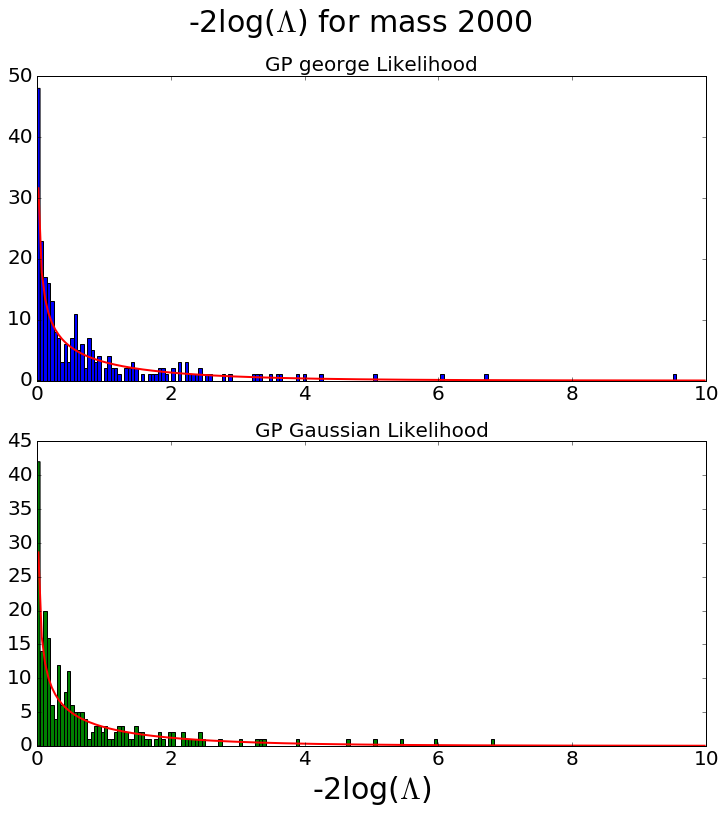

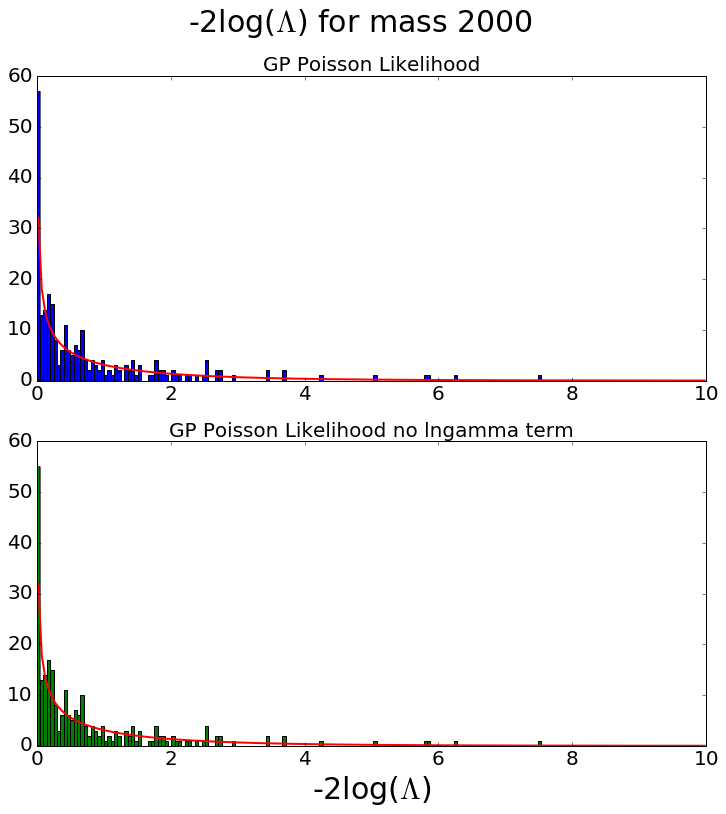

george, gaussian, poisson, poisson with no lngamma % < 0:  1.05 , 15.48 , 78.45 , 78.45


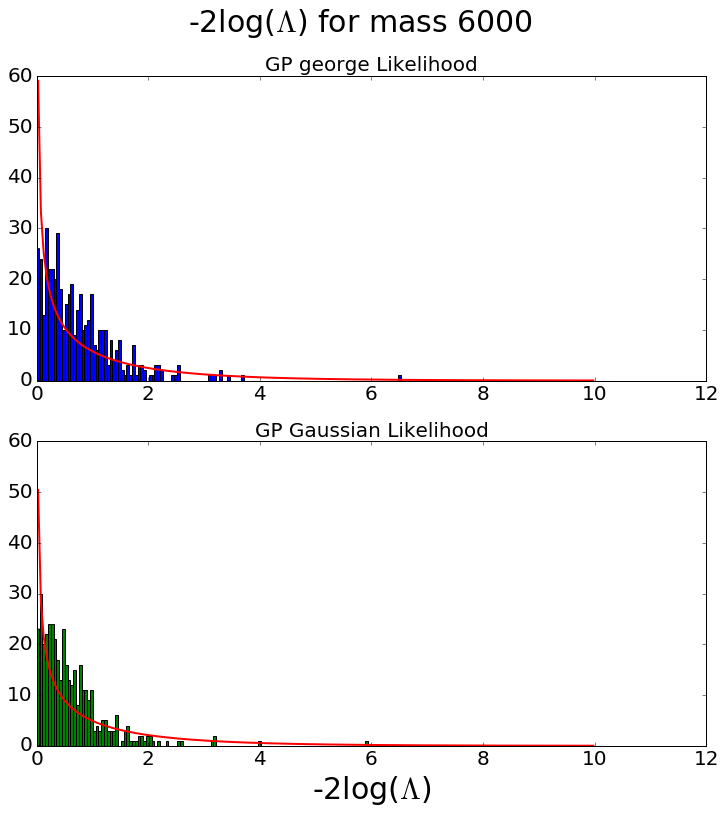

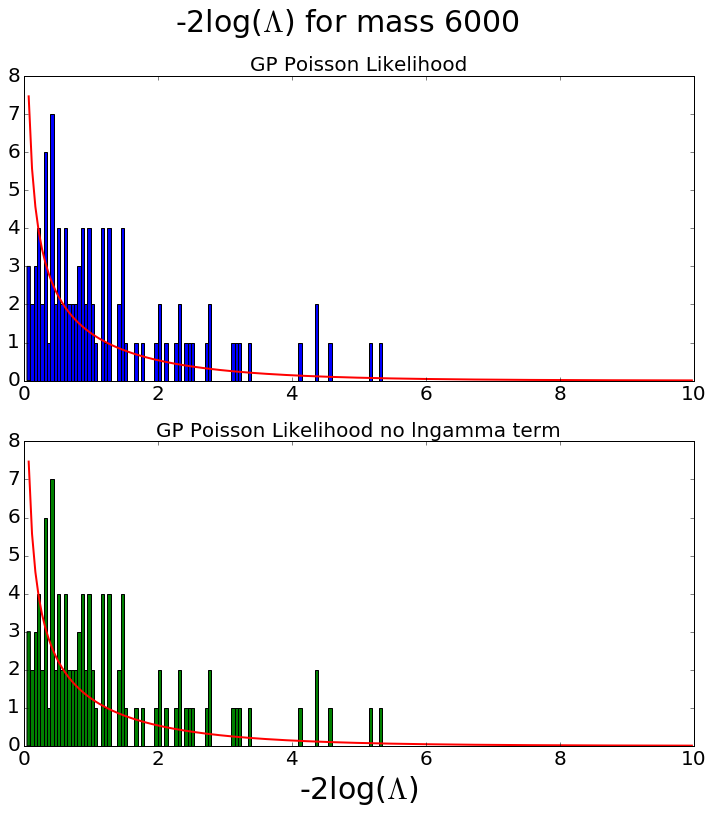

In [67]:
standardParamSets = [(1500,2000,250), (15, 6000,250)]
msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]
GPlist=[]
GPlistP=[]
GPlistG=[]
GPlistng=[]
for m in msignals:

    gp = [s for s in LLlistGP[m] if not (np.isinf(s) or np.isnan(s))]
    G = [s for s in LLlistGPG[m] if not (np.isinf(s) or np.isnan(s))]
    ng = [s for s in LLlistGPng[m] if not (np.isinf(s) or np.isnan(s))]
    P = [s for s in LLlistGPP[m] if not (np.isinf(s) or np.isnan(s))]
    
    gp_neg_frac = round(100.*sum(i < 0 for i in gp)/len(gp),2)
    gpG_neg_frac = round(100.*sum(i < 0 for i in G)/len(G),2)
    gpng_neg_frac = round(100.*sum(i < 0 for i in ng)/len(ng), 2)
    gpP_neg_frac = round(100.*sum(i < 0 for i in P)/len(P),2)
    
    print "george, gaussian, poisson, poisson with no lngamma % < 0: ", gp_neg_frac, ",", gpG_neg_frac,",", gpP_neg_frac, ",", gpng_neg_frac
    
    GPlist.append([np.median(np.array(gp)), np.std(np.array(gp))/np.sqrt(len(gp))])
    GPlistP.append([np.median(np.array(P)), np.std(np.array(P))/np.sqrt(len(P))])

    gp = [s for s in gp if s > 0]
    G = [s for s in G if s > 0]
    ng = [s for s in ng if s > 0]
    P = [s for s in P if s > 0]

    label = r"-2log($\Lambda$) for mass "+str(int(m))
    makePrettyPlots_LLH(gp, G, label, drawchi2=True, xname = r"-2log($\Lambda$)", label1 ="GP george Likelihood", label2 = "GP Gaussian Likelihood")
    makePrettyPlots_LLH(P, ng, label, drawchi2=True, xname = r"-2log($\Lambda$)", label1 ="GP Poisson Likelihood", label2 = "GP Poisson Likelihood no lngamma term")


### Plot LLH ratio with chi2 overlaid for 3 parameter fit function and 5 parameter fit function

1000
3 parameter poisson, gaussian, poisson with no lngamma % < 0:  36.6 , 27.9 , 48.31
5 parameter poisson, gaussian, poisson with no lngamma % < 0:  36.8 , 38.3 , 45.92
2.18775325633e-07
2.74738981565e-07
4.43115433235e-08
1.71910643998e-05
2.00240544701e-06
5.19963960777e-08
2.29474799163e-06
4.53581616711e-09
1.43314804468e-09
1.20586435282e-07
4.03077815569e-07
3.13399629526e-05
1.44514022415e-06
8.17908740736e-08
2.78437138901e-06
3.70783532599e-05
5.79787184929e-06
8.4487794727e-05
3.09245605234e-06
2.24358454037e-07
4.63118950966e-06
1.93632310186e-07
3.84824722088e-06
1.27791300319e-06
6.48401071168e-06
1.22667896951e-06
1.07327801091e-06
1.31377993484e-06
1.19825162015e-06
4.19700341148e-07
2.24651608982e-06
3.21298765371e-06
9.42584416075e-07
9.52964507306e-07
3.22885473913e-07
5.92348392559e-09
5.3168407399e-06
1.29181673691e-05
3.87018778136e-06
5.55145096559e-07
0.000176566654359
1.16591580945e-05
3.62973431312e-06
8.31919757527e-06
1.12126341545e-07
3.99482197322e-07
1.6

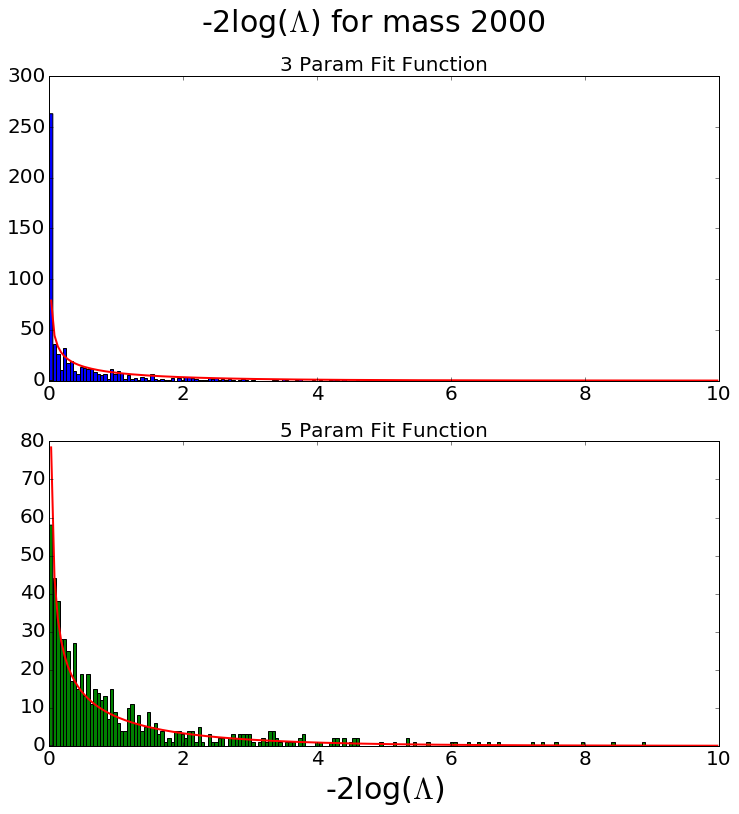

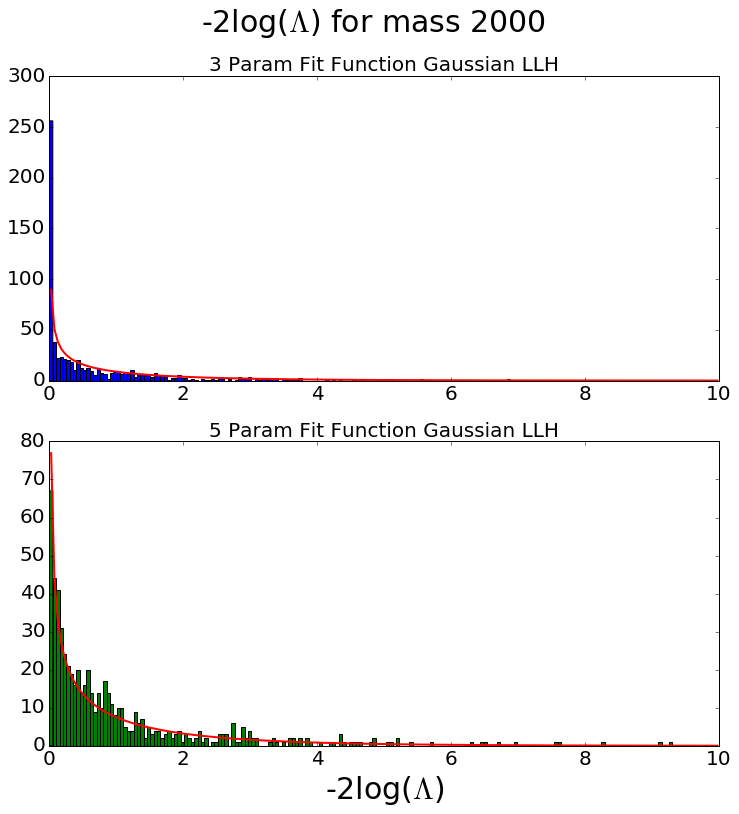

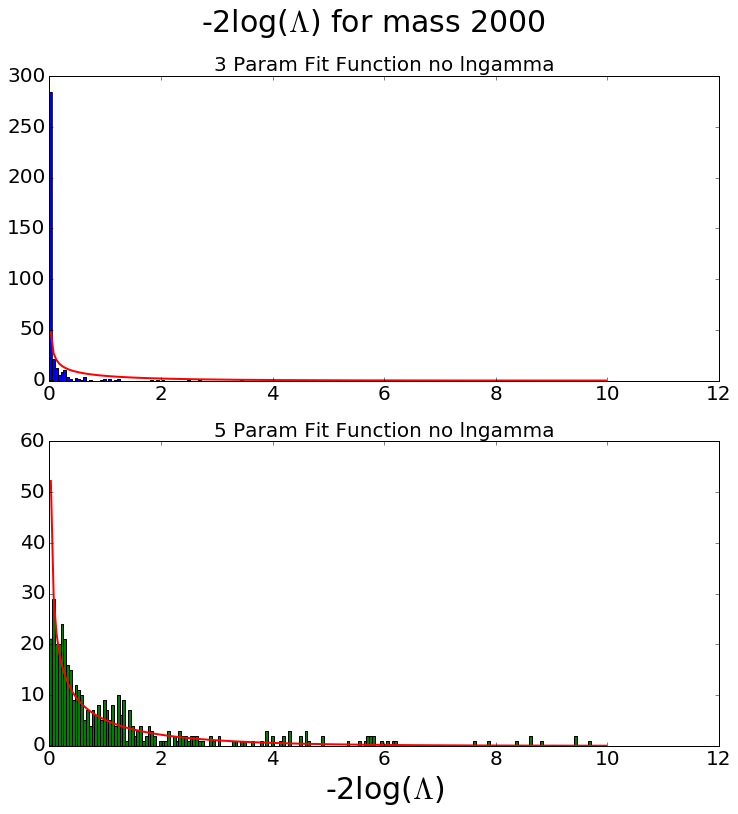

3 parameter poisson, gaussian, poisson with no lngamma % < 0:  35.7 , 7.4 , 59.69
5 parameter poisson, gaussian, poisson with no lngamma % < 0:  41.2 , 18.4 , 45.8
3.69945837853e-06
2.26008656234e-08
1.01647477102e-06
4.56468196575e-11
4.04951738808e-08
5.90682058821e-08
8.64518456822e-09
1.9665205131e-06
5.29076782385e-10
2.39802638857e-07
4.18868884022e-08
3.15858450506e-12
1.84598186737e-07
2.80673817521e-09
1.52729501268e-07
8.8435818113e-07
3.08454373155e-09
7.28002935713e-08
3.60822483003e-13
3.18089998785e-10
1.44188916362e-07
1.39517239983e-06
3.55539542252e-07
7.11699271738e-07
1.39108946584e-08
6.66773518065e-06
4.79616346638e-12
3.82961961032e-06
2.30101249166e-07
2.23455152715e-06
7.88484277869e-08
3.78678199908e-09
3.72998870679e-07
3.30050986541e-09
1.04885072849e-07
9.16012105057e-07
1.18046955544e-07
6.50660636481e-09
4.27427758742e-06
4.67339526522e-06
1.93333973053e-05
7.53048512436e-08
4.44704928437e-07
1.70606473393e-08
4.62775595622e-07
4.99284197319e-07
1.44510441

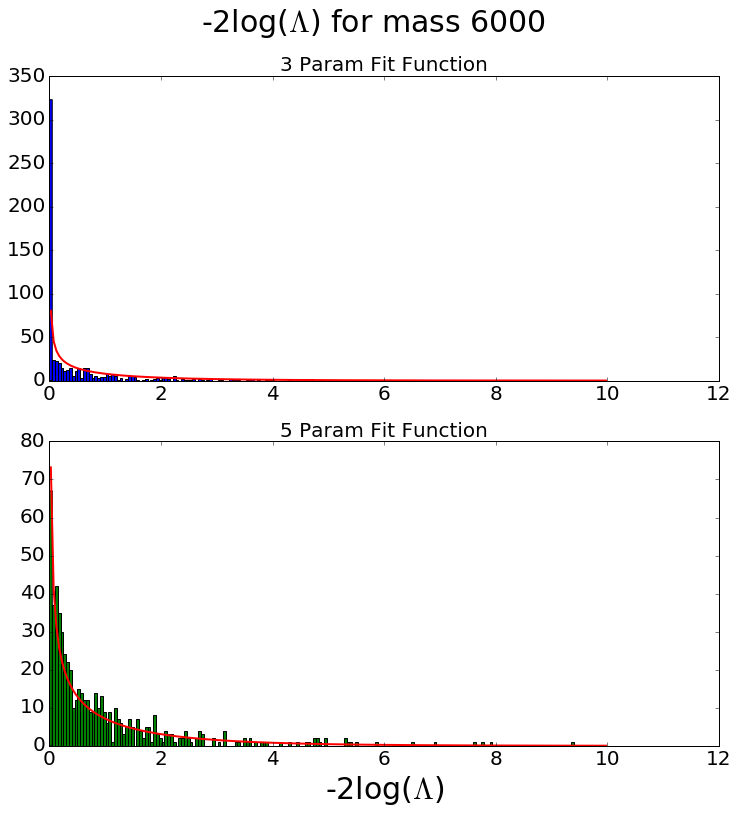

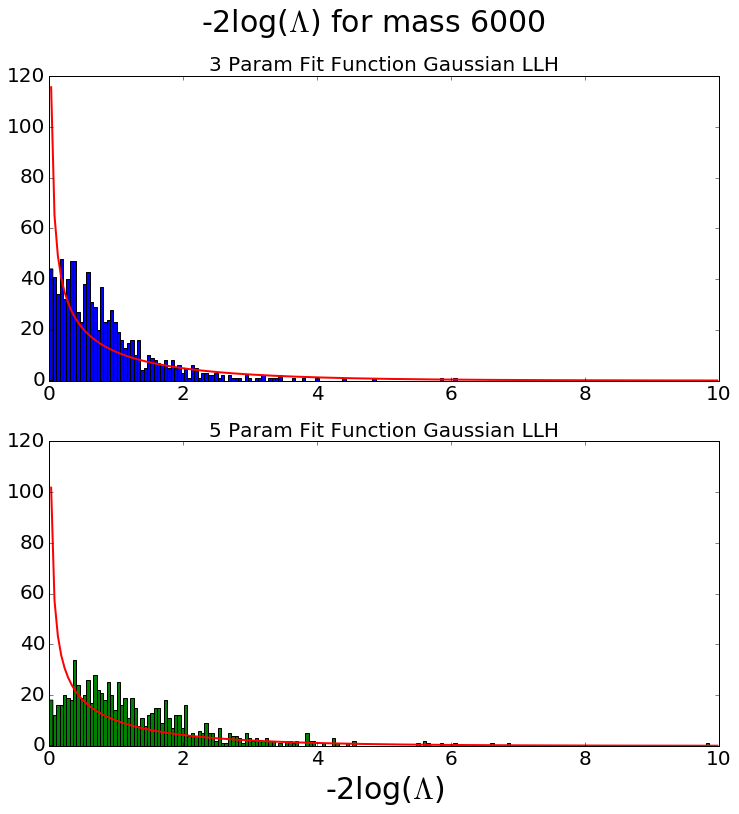

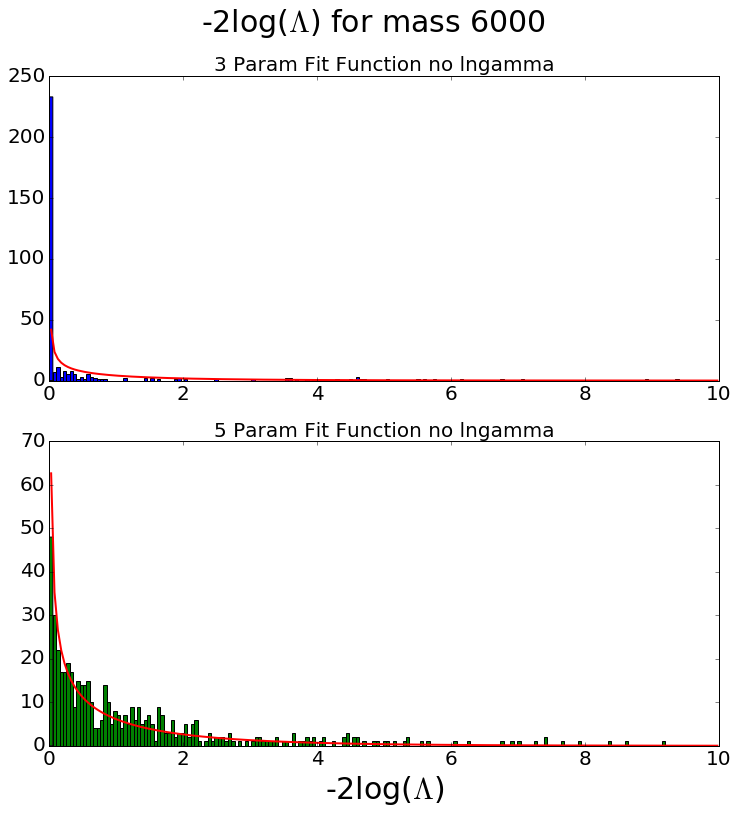

In [100]:
standardParamSets = [(1500,2000,250), (15, 6000,250)]
msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]

print len(LLlistFF3[2000])
FFlist3=[]
FFlist5=[]
FFlist3G=[]
FFlist5G=[]
FFlist3ng=[]
FFlist5ng=[]
for m in msignals:

    ff3 = [s for s in LLlistFF3[m] if not (np.isinf(s) or np.isnan(s))] 
    ff5 = [s for s in LLlistFF5[m] if not (np.isinf(s) or np.isnan(s))]  
    ff3G = [s for s in LLlistFF3G[m] if not (np.isinf(s) or np.isnan(s))] 
    ff5G = [s for s in LLlistFF5G[m] if not (np.isinf(s) or np.isnan(s))] 
    ff3ng = [s for s in LLlistFF3ng[m] if not (np.isinf(s) or np.isnan(s))] 
    ff5ng = [s for s in LLlistFF5ng[m] if not (np.isinf(s) or np.isnan(s))] 
    
    ff3_neg_frac = round(100.*sum(i < 0 for i in ff3)/len(ff3),2)
    ffG3_neg_frac = round(100.*sum(i < 0 for i in ff3G)/len(ff3G),2)
    ffng3_neg_frac = round(100.*sum(i < 0 for i in ff3ng)/len(ff3ng),2)
    ff5_neg_frac = round(100.*sum(i < 0 for i in ff5)/len(ff5),2)
    ffG5_neg_frac = round(100.*sum(i < 0 for i in ff5G)/len(ff5G),2)
    ffng5_neg_frac = round(100.*sum(i < 0 for i in ff5ng)/len(ff5ng),2)
    
    print "3 parameter poisson, gaussian, poisson with no lngamma % < 0: ", ff3_neg_frac, ",",ffG3_neg_frac, ",",ffng3_neg_frac
    print "5 parameter poisson, gaussian, poisson with no lngamma % < 0: ", ff5_neg_frac, ",",ffG5_neg_frac, ",",ffng5_neg_frac
    
    
    FFlist3.append([np.median(np.array(ff3)), np.std(np.array(ff3)/np.sqrt(len(ff3)))])
    FFlist5.append([np.median(np.array(ff5)), np.std(np.array(ff5)/np.sqrt(len(ff5)))])
    FFlist3G.append([np.median(np.array(ff3G)), np.std(np.array(ff3G)/np.sqrt(len(ff3G)))])
    FFlist5G.append([np.median(np.array(ff5G)), np.std(np.array(ff5G)/np.sqrt(len(ff5G)))])
    FFlist3ng.append([np.median(np.array(ff3ng)), np.std(np.array(ff3ng)/np.sqrt(len(ff3ng)))])
    FFlist5ng.append([np.median(np.array(ff5ng)), np.std(np.array(ff5ng)/np.sqrt(len(ff5ng)))])
    
    for i in range(len(ff3)):
        if ff3[i]<0: print paramlistFF3_sb[m][i][-1]
        
    ff3 = [s for s in ff3 if s > 0]
    ff3G = [s for s in ff3G if s > 0]
    ff3ng = [s for s in ff3ng if s > 0]
    ff5 = [s for s in ff5 if s > 0]
    ff5G = [s for s in ff5G if s > 0]
    ff5ng = [s for s in ff5ng if s > 0]
    
    label = r"-2log($\Lambda$) for mass "+str(int(m))
    makePrettyPlots_LLH(ff3, ff5, label, drawchi2=True, xname =r"-2log($\Lambda$)", label1="3 Param Fit Function", label2 = "5 Param Fit Function" )
    makePrettyPlots_LLH(ff3G, ff5G, label, drawchi2=True, xname =r"-2log($\Lambda$)", label1="3 Param Fit Function Gaussian LLH", label2 = "5 Param Fit Function Gaussian LLH" )
    makePrettyPlots_LLH(ff3ng, ff5ng, label, drawchi2=True, xname =r"-2log($\Lambda$)", label1="3 Param Fit Function no lngamma", label2 = "5 Param Fit Function no lngamma" )


### From before

In [57]:
LLlistSTD3_b={}
LLlistSTD5_b={}
LLlistGP_b={} 
LLlistGPP_b={} 
LLlistSTD3_b[3500] = np.load("savedOutputs/LLHR_3param_3500_noSignal.npy")
LLlistSTD5_b[3500] = np.load("savedOutputs/LLHR_5param_3500_noSignal.npy")
LLlistGP_b[3500] = np.load("savedOutputs/LLHR_GP_3500_noSignal.npy")
LLlistGPP_b[3500] = np.load("savedOutputs/LLHR_GP_other_3500_noSignal.npy")

GP george % < 0:  57.0
GP Poisson % < 0:  44.04


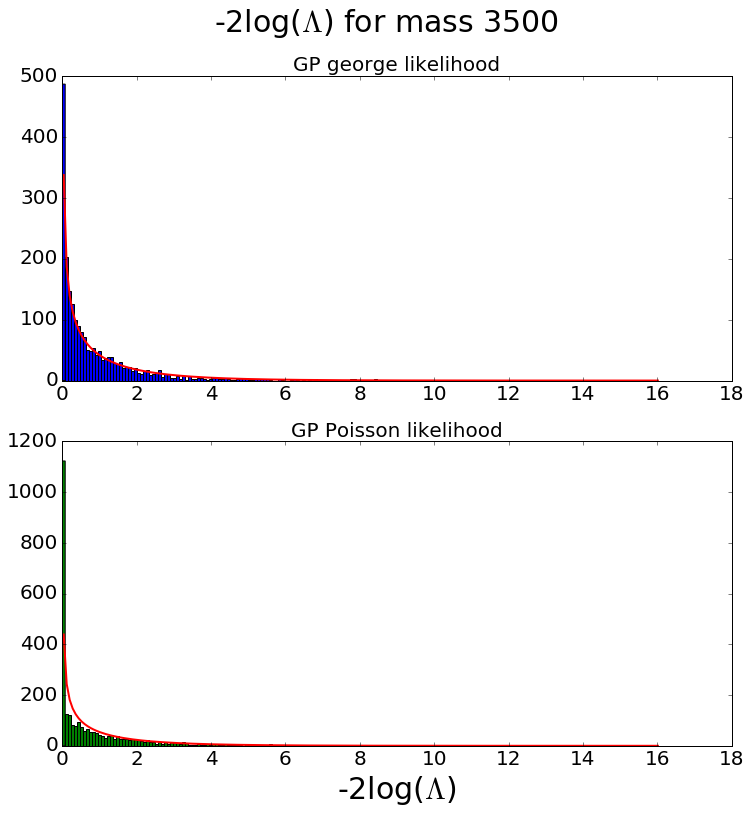

In [60]:
msignals = [3500] 

GPlistb=[]
GPPlistb=[]
for m in msignals:

    gp = [s for s in LLlistGP_b[m] if not (np.isinf(s) or np.isnan(s))] 
    P = [s for s in LLlistGPP_b[m] if not (np.isinf(s) or np.isnan(s))]  
    
    gp_neg_frac = round(100.*sum(i < 0 for i in gp)/len(gp),2)
    P_neg_frac = round(100.*sum(i < 0 for i in P)/len(P),2)
    
    print "GP george % < 0: ", gp_neg_frac
    print "GP Poisson % < 0: ", P_neg_frac
    
    
    GPlistb.append([np.median(np.array(gp)), np.std(np.array(gp)/np.sqrt(len(gp)))])
    GPPlistb.append([np.median(np.array(P)), np.std(np.array(P)/np.sqrt(len(P)))])

    
    gp = [s for s in gp if s > 0]
    P = [s for s in P if s > 0]
    
    label = r"-2log($\Lambda$) for mass "+str(int(m))
    makePrettyPlots_LLH(gp, P, label, drawchi2=True, xname =r"-2log($\Lambda$)", label1="GP george likelihood", label2 = "GP Poisson likelihood" )



3 parameter poisson % < 0:  27.21
5 parameter poisson % < 0:  36.77


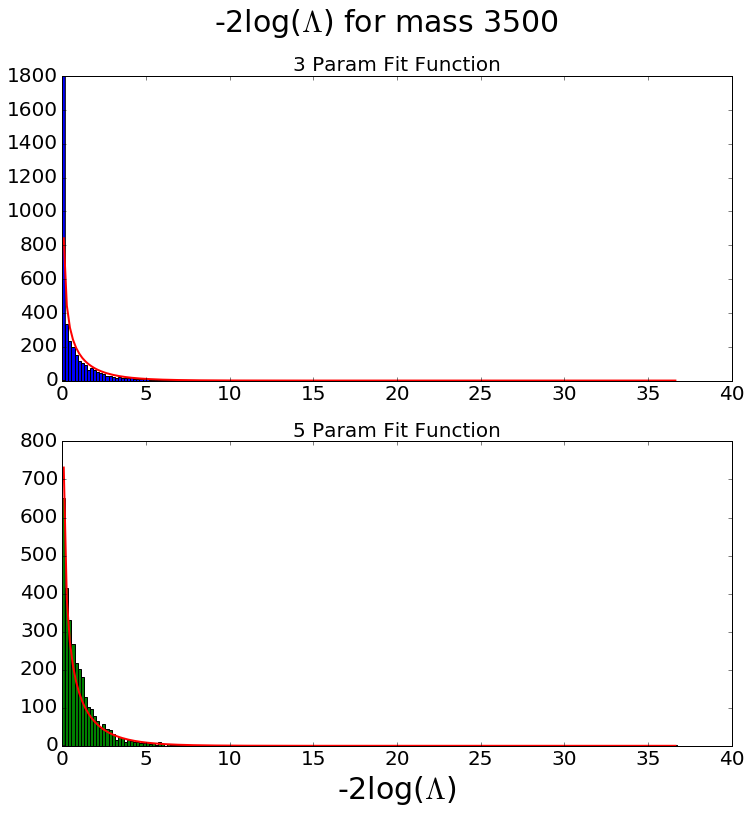

In [59]:
msignals = [3500] 

FFlist3b=[]
FFlist5b=[]
for m in msignals:

    ff3 = [s for s in LLlistSTD3_b[m] if not (np.isinf(s) or np.isnan(s))] 
    ff5 = [s for s in LLlistSTD5_b[m] if not (np.isinf(s) or np.isnan(s))]  
    
    ff3_neg_frac = round(100.*sum(i < 0 for i in ff3)/len(ff3),2)
    ff5_neg_frac = round(100.*sum(i < 0 for i in ff5)/len(ff5),2)
    
    print "3 parameter poisson % < 0: ", ff3_neg_frac
    print "5 parameter poisson % < 0: ", ff5_neg_frac
    
    
    FFlist3b.append([np.median(np.array(ff3)), np.std(np.array(ff3)/np.sqrt(len(ff3)))])
    FFlist5b.append([np.median(np.array(ff5)), np.std(np.array(ff5)/np.sqrt(len(ff5)))])

    
    ff3 = [s for s in ff3 if s > 0]
    ff5 = [s for s in ff5 if s > 0]
    
    label = r"-2log($\Lambda$) for mass "+str(int(m))
    makePrettyPlots_LLH(ff3, ff5, label, drawchi2=True, xname =r"-2log($\Lambda$)", label1="3 Param Fit Function", label2 = "5 Param Fit Function" )


In [170]:
def plotBestFitParams(paramList, paramNames,  title):
    f, ax = plt.subplots(1, len(paramList[0]), figsize=(15,5))
    f.suptitle(title, fontsize=20, y = 1.08)
    paramList = [s for s in paramList if not all([True if b == 0 else False for b in s])]
    for iparam in range(len(paramList[0])):
        ax[iparam].set_xlabel(paramNames[iparam], fontsize=15)
        p = [paramList[i][iparam] for i in range(len(paramList))]
        ax[iparam].hist(p, bins=np.linspace(min(p), max(p), 50))
        ax[iparam].axvline(np.mean(p), color='r', linestyle='dashed', linewidth=2)
        ax[iparam].annotate(str(round(np.mean(p),3)), xy=(0.75, 0.75), xycoords='axes fraction')

### Plot average LLH ratio over toys as a function of signal mass

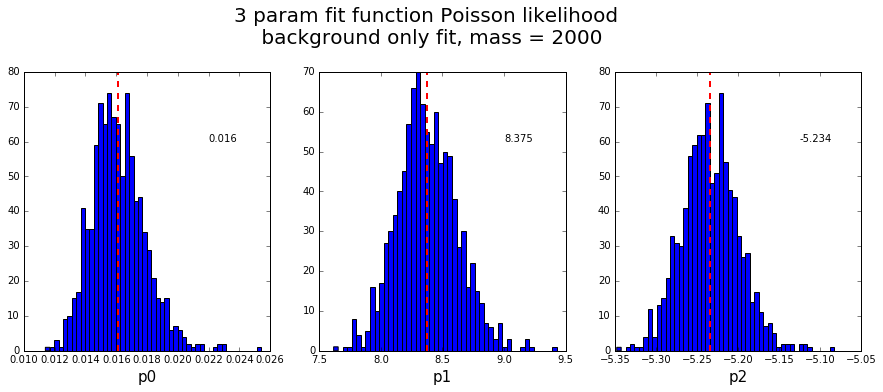

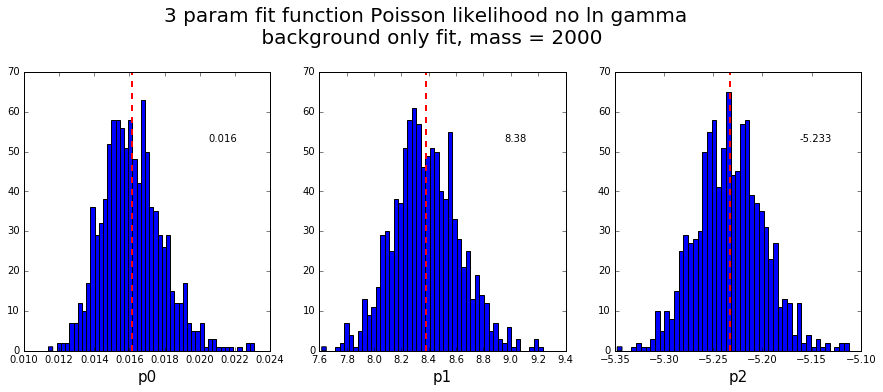

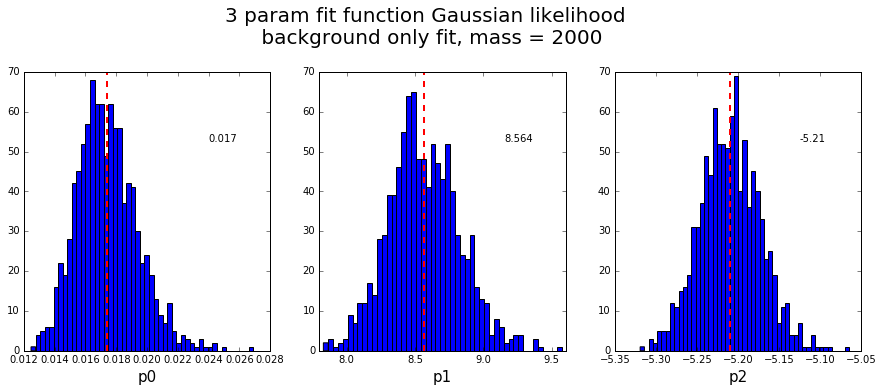

In [171]:
msignals = [2000]
for m in msignals:
    plotBestFitParams(paramlistFF3_b[m], ['p0','p1','p2'], "3 param fit function Poisson likelihood \n background only fit, mass = " + str(m))
    plotBestFitParams(paramlistFF3ng_b[m], ['p0','p1','p2'], "3 param fit function Poisson likelihood no ln gamma \n background only fit, mass = " + str(m))
    plotBestFitParams(paramlistFF3G_b[m], ['p0','p1','p2'], "3 param fit function Gaussian likelihood \n background only fit, mass = " + str(m))

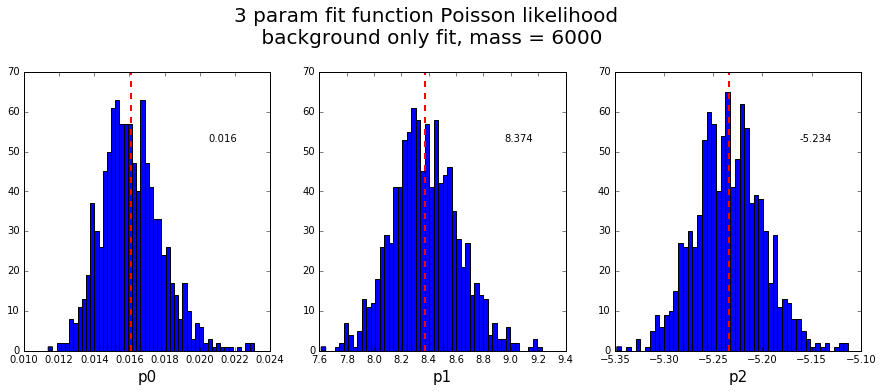

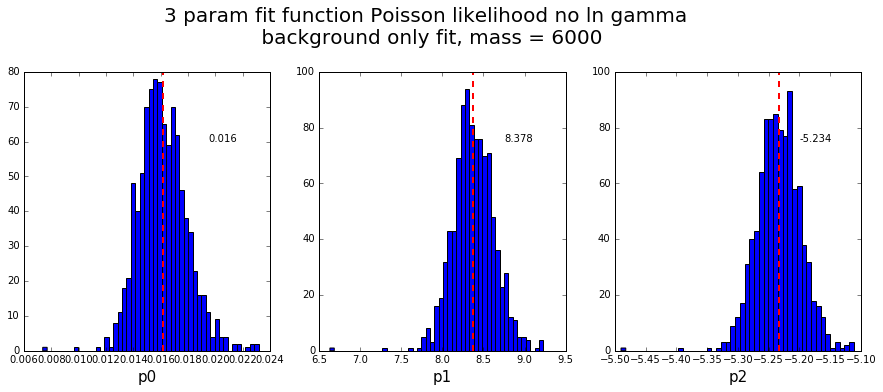

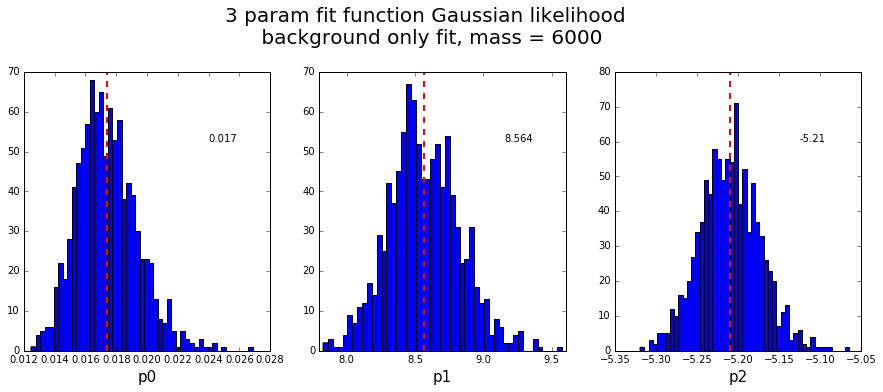

In [172]:
msignals = [6000]
for m in msignals:
    plotBestFitParams(paramlistFF3_b[m], ['p0','p1','p2'], "3 param fit function Poisson likelihood \n background only fit, mass = " + str(m))
    plotBestFitParams(paramlistFF3ng_b[m], ['p0','p1','p2'], "3 param fit function Poisson likelihood no ln gamma \n background only fit, mass = " + str(m))
    plotBestFitParams(paramlistFF3G_b[m], ['p0','p1','p2'], "3 param fit function Gaussian likelihood \n background only fit, mass = " + str(m))

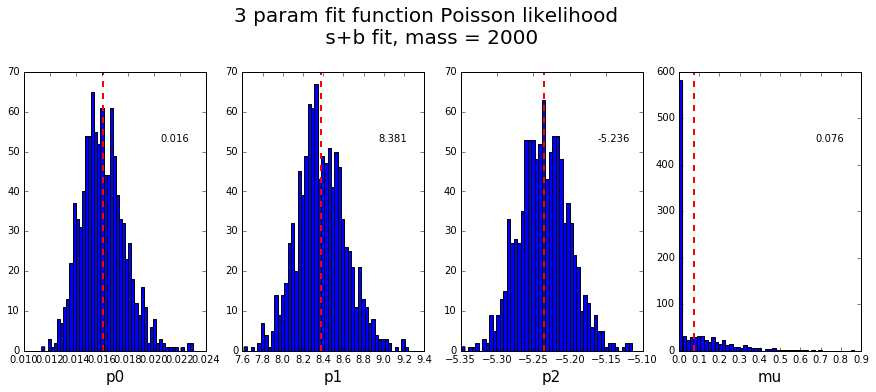

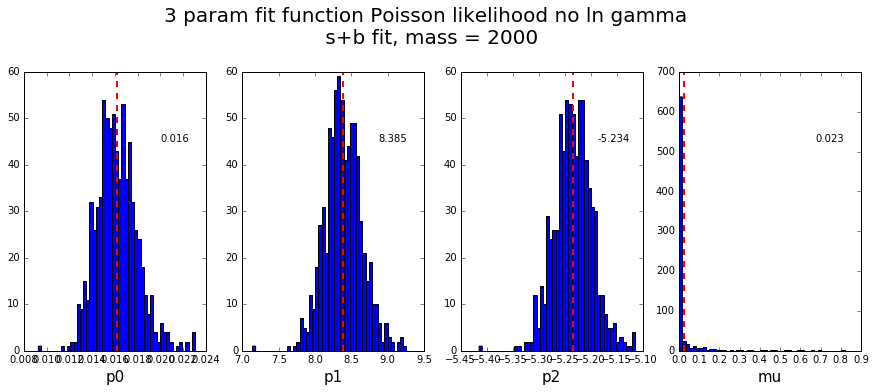

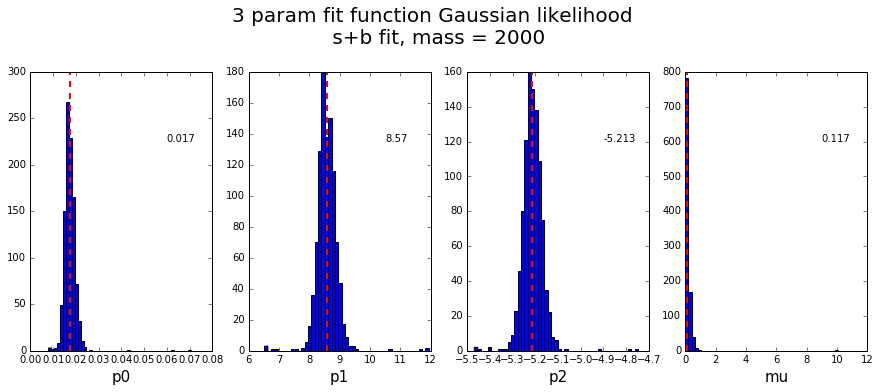

In [173]:
msignals = [2000]
for m in msignals:
    plotBestFitParams(paramlistFF3_sb[m], ['p0','p1','p2','mu'], "3 param fit function Poisson likelihood \n s+b fit, mass = " + str(m))
    plotBestFitParams(paramlistFF3ng_sb[m], ['p0','p1','p2','mu'], "3 param fit function Poisson likelihood no ln gamma \n s+b fit, mass = " + str(m))
    plotBestFitParams(paramlistFF3G_sb[m], ['p0','p1','p2','mu'], "3 param fit function Gaussian likelihood \n s+b fit, mass = " + str(m))

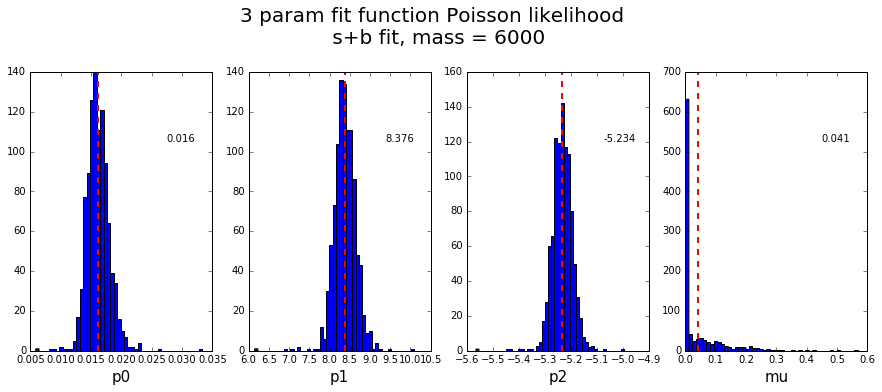

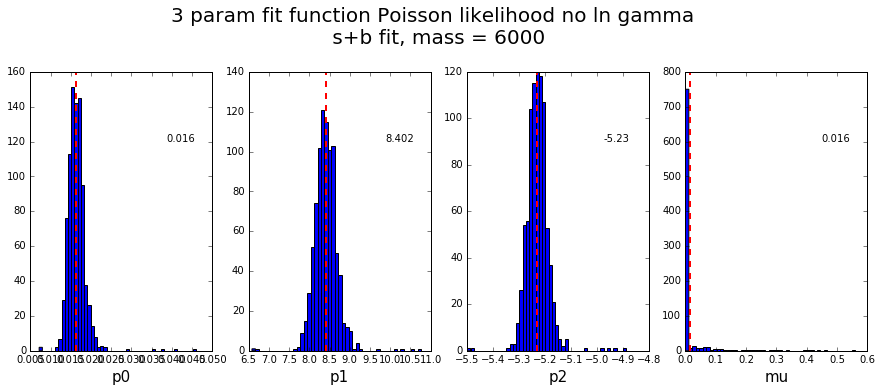

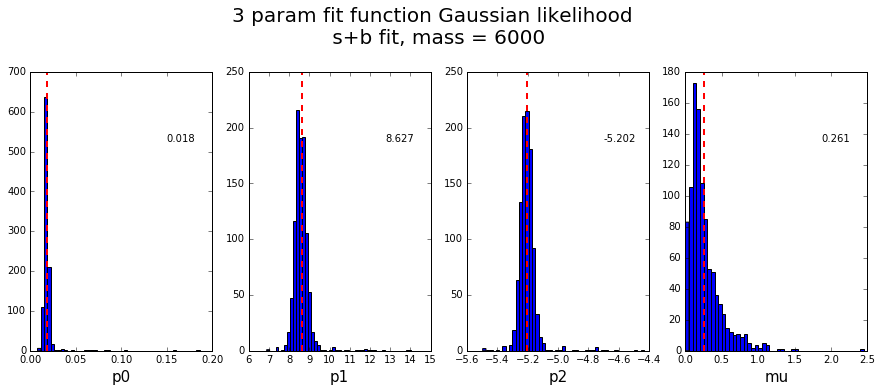

In [174]:
msignals = [6000]
for m in msignals:
    plotBestFitParams(paramlistFF3_sb[m], ['p0','p1','p2','mu'], "3 param fit function Poisson likelihood \n s+b fit, mass = " + str(m))
    plotBestFitParams(paramlistFF3ng_sb[m], ['p0','p1','p2','mu'], "3 param fit function Poisson likelihood no ln gamma \n s+b fit, mass = " + str(m))
    plotBestFitParams(paramlistFF3G_sb[m], ['p0','p1','p2','mu'], "3 param fit function Gaussian likelihood \n s+b fit, mass = " + str(m))

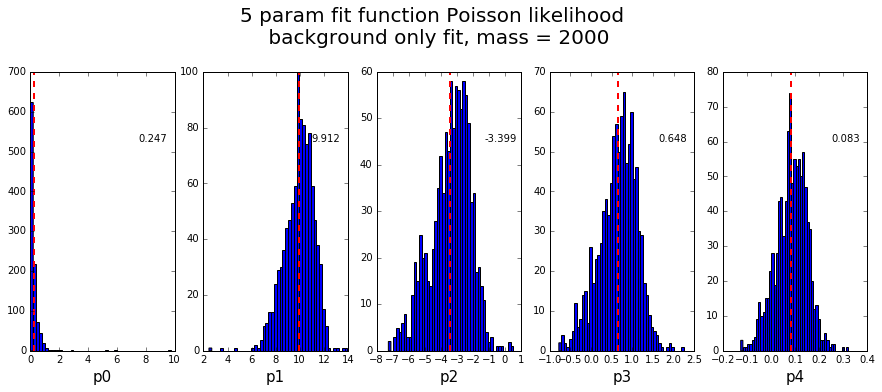

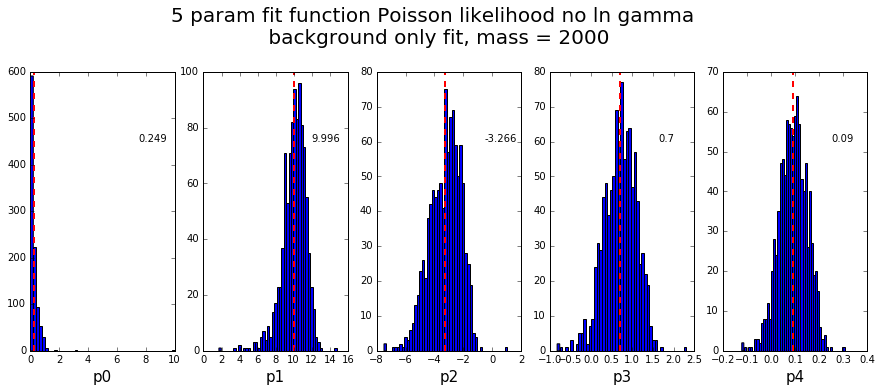

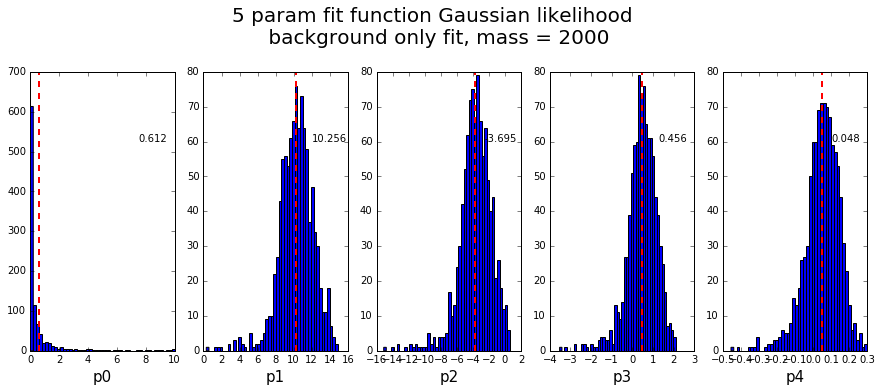

In [175]:
msignals = [2000]
for m in msignals:
    plotBestFitParams(paramlistFF5_b[m], ['p0','p1','p2','p3','p4'], "5 param fit function Poisson likelihood \n background only fit, mass = " + str(m))
    plotBestFitParams(paramlistFF5ng_b[m], ['p0','p1','p2','p3','p4'], "5 param fit function Poisson likelihood no ln gamma \n background only fit, mass = " + str(m))
    plotBestFitParams(paramlistFF5G_b[m], ['p0','p1','p2','p3','p4'], "5 param fit function Gaussian likelihood \n background only fit, mass = " + str(m))

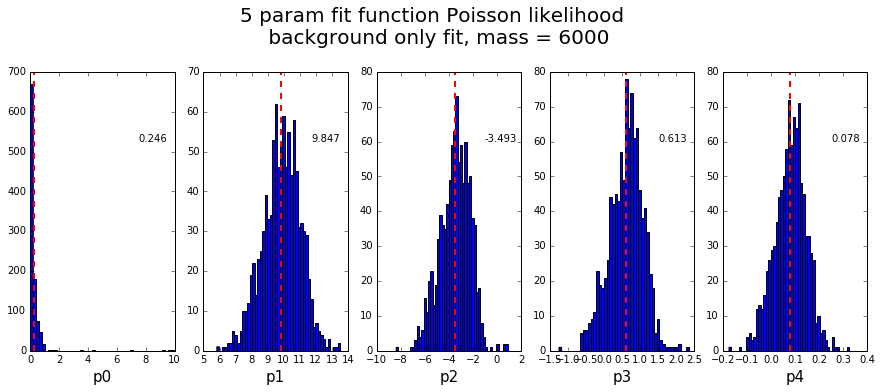

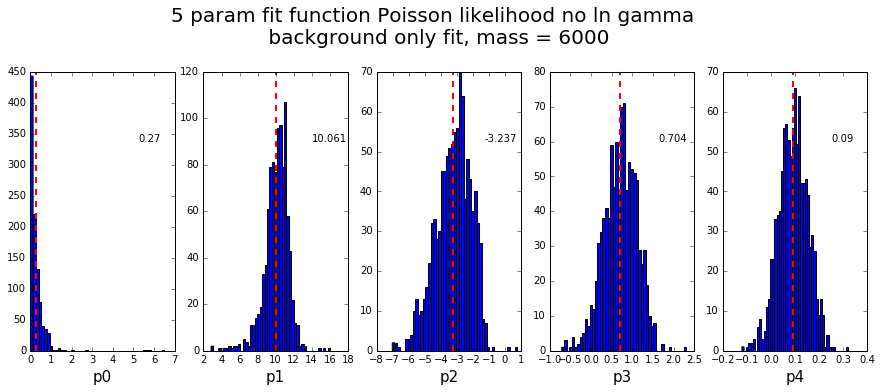

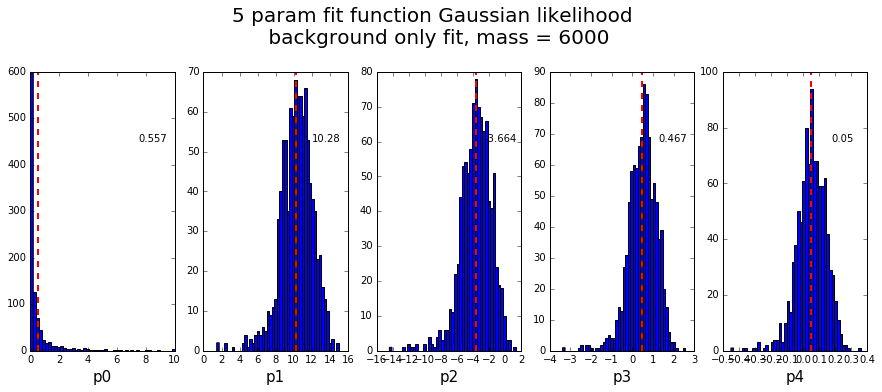

In [176]:
msignals = [6000]
for m in msignals:
    plotBestFitParams(paramlistFF5_b[m], ['p0','p1','p2','p3','p4'], "5 param fit function Poisson likelihood \n background only fit, mass = " + str(m))
    plotBestFitParams(paramlistFF5ng_b[m], ['p0','p1','p2','p3','p4'], "5 param fit function Poisson likelihood no ln gamma \n background only fit, mass = " + str(m))
    plotBestFitParams(paramlistFF5G_b[m], ['p0','p1','p2','p3','p4'], "5 param fit function Gaussian likelihood \n background only fit, mass = " + str(m))

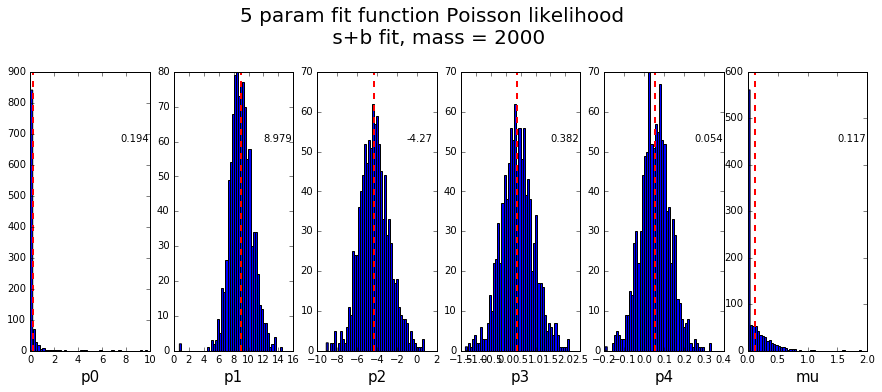

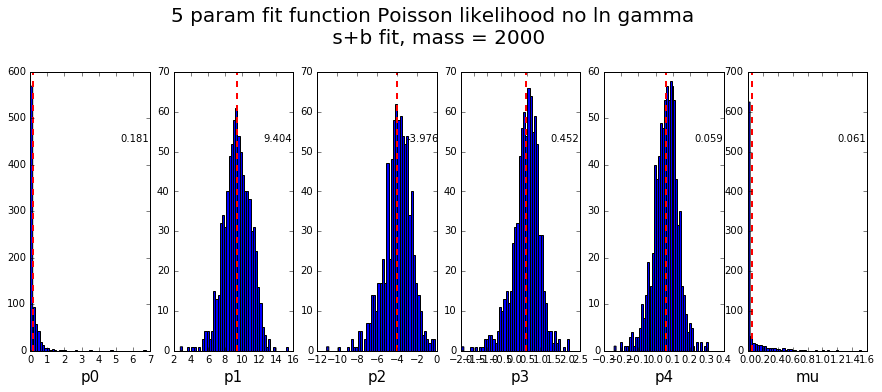

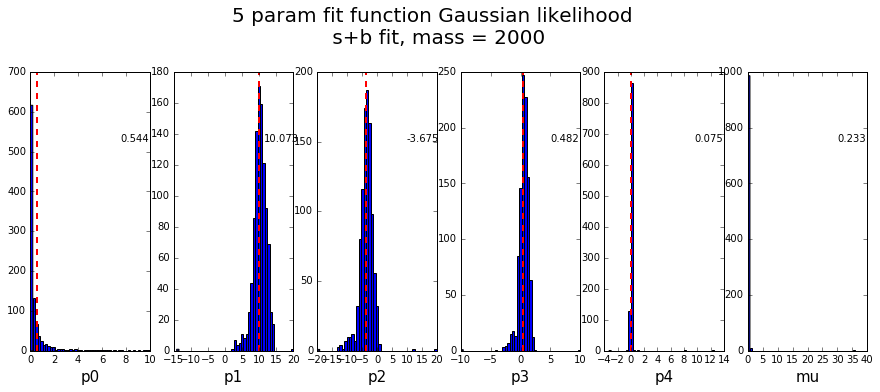

In [177]:
msignals = [2000]
for m in msignals:
    plotBestFitParams(paramlistFF5_sb[m], ['p0','p1','p2','p3','p4','mu'], "5 param fit function Poisson likelihood \n s+b fit, mass = " + str(m))
    plotBestFitParams(paramlistFF5ng_sb[m], ['p0','p1','p2','p3','p4','mu'], "5 param fit function Poisson likelihood no ln gamma \n s+b fit, mass = " + str(m))
    plotBestFitParams(paramlistFF5G_sb[m], ['p0','p1','p2','p3','p4','mu'], "5 param fit function Gaussian likelihood \n s+b fit, mass = " + str(m))

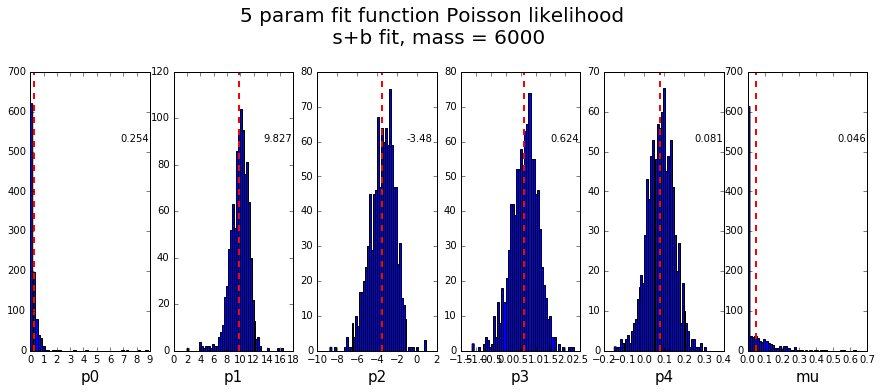

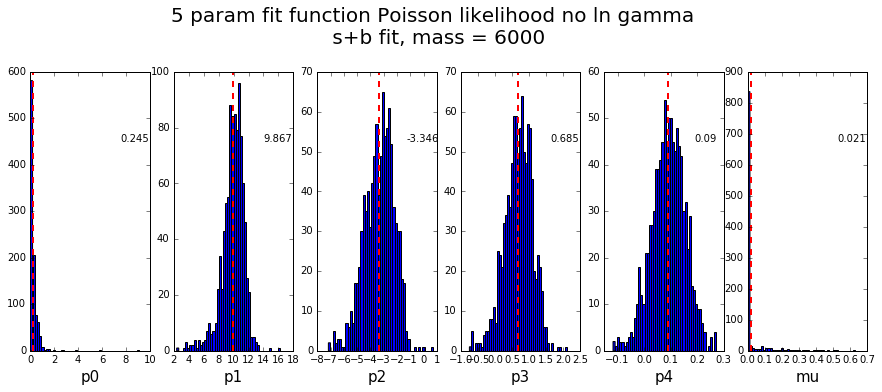

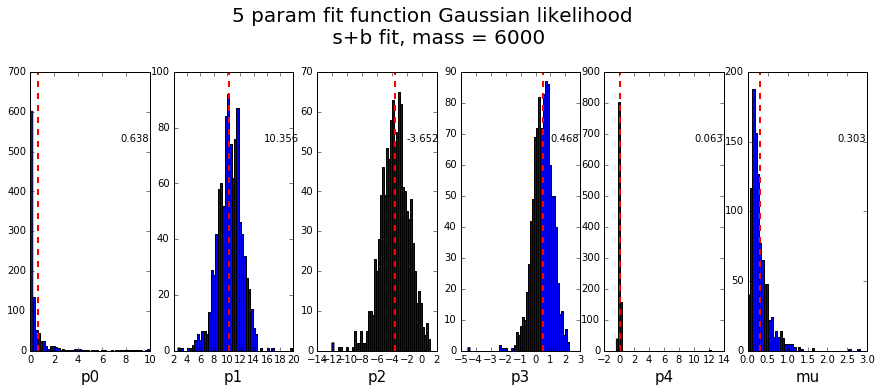

In [178]:
msignals = [6000]
for m in msignals:
    plotBestFitParams(paramlistFF5_sb[m], ['p0','p1','p2','p3','p4','mu'], "5 param fit function Poisson likelihood \n s+b fit, mass = " + str(m))
    plotBestFitParams(paramlistFF5ng_sb[m], ['p0','p1','p2','p3','p4','mu'], "5 param fit function Poisson likelihood no ln gamma \n s+b fit, mass = " + str(m))
    plotBestFitParams(paramlistFF5G_sb[m], ['p0','p1','p2','p3','p4','mu'], "5 param fit function Gaussian likelihood \n s+b fit, mass = " + str(m))

In [74]:
#GPlist.insert(1, GPlistb[0])
#GPlistP.insert(1, GPPlistb[0])
#FFlist3.insert(1, FFlist3b[0])

[5.165077067204038e-05, 0.0066095004166299987, 4.0356490103476972e-05]
[0.00034767934351975782, -6.5864469434018247e-10, 0.56137661914021919]
[2.6162172162003117e-07, 1.3447845503833378e-07, -1.4429608667566072]


(1e-10, 2500)

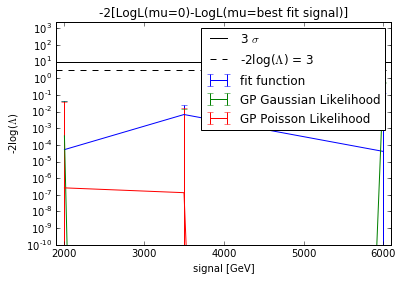

In [77]:
msignals = [2000, 3500, 6000]
print [FFlist3[i][0] for i in range(len(msignals))]
print [GPlist[i][0] for i in range(len(msignals))]
print [GPlistP[i][0] for i in range(len(msignals))]
plt.figure()
plt.errorbar(msignals, [FFlist3[i][0] for i in range(len(msignals))] , yerr = [FFlist3[i][1] for i in range(len(msignals))], color="b", label="fit function")
plt.errorbar(msignals, [GPlist[i][0] for i in range(len(msignals))], yerr = [GPlist[i][1] for i in range(len(msignals))], color="g", label="GP Gaussian Likelihood")
plt.errorbar(msignals, [GPlistP[i][0] for i in range(len(msignals))], yerr = [GPlistP[i][1] for i in range(len(msignals))], color="r", label="GP Poisson Likelihood")
plt.plot([1900,6100], 10*np.ones(2), c='black', label=r'3 $\sigma$')
plt.plot([1900,6100], 3*np.ones(2), c='black', ls='--', label=r"-2log($\Lambda$) = 3")

plt.xlabel("signal [GeV]")
plt.yscale('log', nonposy="clip")
plt.xlim([1900, 6100])
plt.title("-2[LogL(mu=0)-LogL(mu=best fit signal)]")
plt.ylabel(r"-2log($\Lambda$)")
plt.legend(loc=1)
plt.ylim([1e-10, 2500])

[[5.165077067204038e-05, 0.043132805286758197], [4.0356490103476972e-05, 0.12814074866664124]]
